<a href="https://colab.research.google.com/github/DmtrRm/IAAC2024_tutorials/blob/main/plank_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robotic Wood Craft Scanning
This is the code for scanning part in robotic wood craft seminar. It will import images from mounted folder then export cropped object and a csv file which store the id, length, width, R, G, B color information.



In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Usage


*   **Mount your google drive**  
    You can find the google drive icon in the top bar of 'files'
*   **Check the folders**  
    Make sure import images and export images are in separate directory

*   **Run the scripts**  
    This code has two cells, the first one will be definition for the functions, the second one will be the execution module.

*   **Check the results**
    After execute the functions, you will find two images are showing at the bottom of this page. Double check if the id are matching in both images

In [69]:
import cv2
import numpy as np
from copy import deepcopy
import csv
from google.colab.patches import cv2_imshow
import os

def aruco_detector(img):
    arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)

    arucoParams = cv2.aruco.DetectorParameters()

    detector = cv2.aruco.ArucoDetector(arucoDict, arucoParams)

    corners, ids, rejected = detector.detectMarkers(img)


    # sort the corners and ids according to the ids
    if len(corners) > 0:
        corners = [c for _, c in sorted(zip(ids, corners))]
        ids = sorted(ids)

    # convert list to numpy array
    ids = np.array(ids)


    detect_img = cv2.aruco.drawDetectedMarkers(img, corners, ids, (0, 0, 255))

    distance = []

    for corner in corners:
        corner_1 = corner[0][0]
        corner_2 = corner[0][1]
        # calculate the distance between two corners
        dist = np.sqrt(np.sum(np.square(corner_1 - corner_2)))
        distance.append(dist)

    # caltulate pixel to mm ratio
    dist_mean = np.mean(distance)
    pixel_to_mm = 29 / dist_mean

    return corners, ids, detect_img, pixel_to_mm


def background_subtractor(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([44, 0, 0])
    upper_blue = np.array([141, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    mask = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(img, img, mask=mask)

    return mask, result


def image_processor(mask, result, corners, ids, pixel_to_mm):
    contour = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get the longest three contours
    contour = sorted(contour[0], key=lambda x: cv2.arcLength(x, True), reverse=True)[:3]
    # draw contours on the mask
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # sort the contours id according to the center of the marker
    contour_with_id = []
    for c in contour:
        for i in range(len(ids)):
            x = int(np.mean(corners[i][0][:, 0]))
            y = int(np.mean(corners[i][0][:, 1]))
            # put the id text on the image
            if cv2.pointPolygonTest(c, (x, y), False) == 1:
                contour_id = ids[i][0]
                cv2.putText(mask, str(contour_id), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                contour_with_id.append((contour_id, c))

    contour_with_id = sorted(contour_with_id, key=lambda x: x[0])
    # print the id of the contours
    contour_sorted = [c[1] for c in contour_with_id]
    # find the mininum area bounding rectangle
    length = []
    width = []
    boxes = []
    for c in contour_sorted:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        boxes.append(box)
        length_pixel = np.sqrt(np.sum(np.square(box[0] - box[1])))
        width_pixel = np.sqrt(np.sum(np.square(box[1] - box[2])))
        # make sure the longer side is the length
        if length_pixel < width_pixel:
            length_pixel, width_pixel = width_pixel, length_pixel

        l = length_pixel * pixel_to_mm
        w = width_pixel * pixel_to_mm
        length.append(l)
        width.append(w)

    return boxes, contour_sorted, length, width, mask

def export_img(img, contour, path):
    R = []
    G = []
    B = []
    for i in range(len(contour)):
        x, y, w, h = cv2.boundingRect(contour[i])
        # offset the bounding box
        offset = 5
        x = x - offset
        y = y - offset
        w = w + offset * 2
        h = h + offset * 2
        crop = img[y:y + h, x:x + w]

        # calculate the average color for each picture
        avg_color_per_row = np.average(crop, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        B.append(avg_color[0])
        G.append(avg_color[1])
        R.append(avg_color[2])
        cv2.imwrite(path + str(i) + ".jpg", crop)

    return R, G, B


def write_to_csv(data_raw, path):

    headers = ['id', 'length', 'width', 'R', 'G', 'B']
    with open(path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writeheader()
        for row in data_raw:
            writer.writerow(dict(zip(headers, row)))

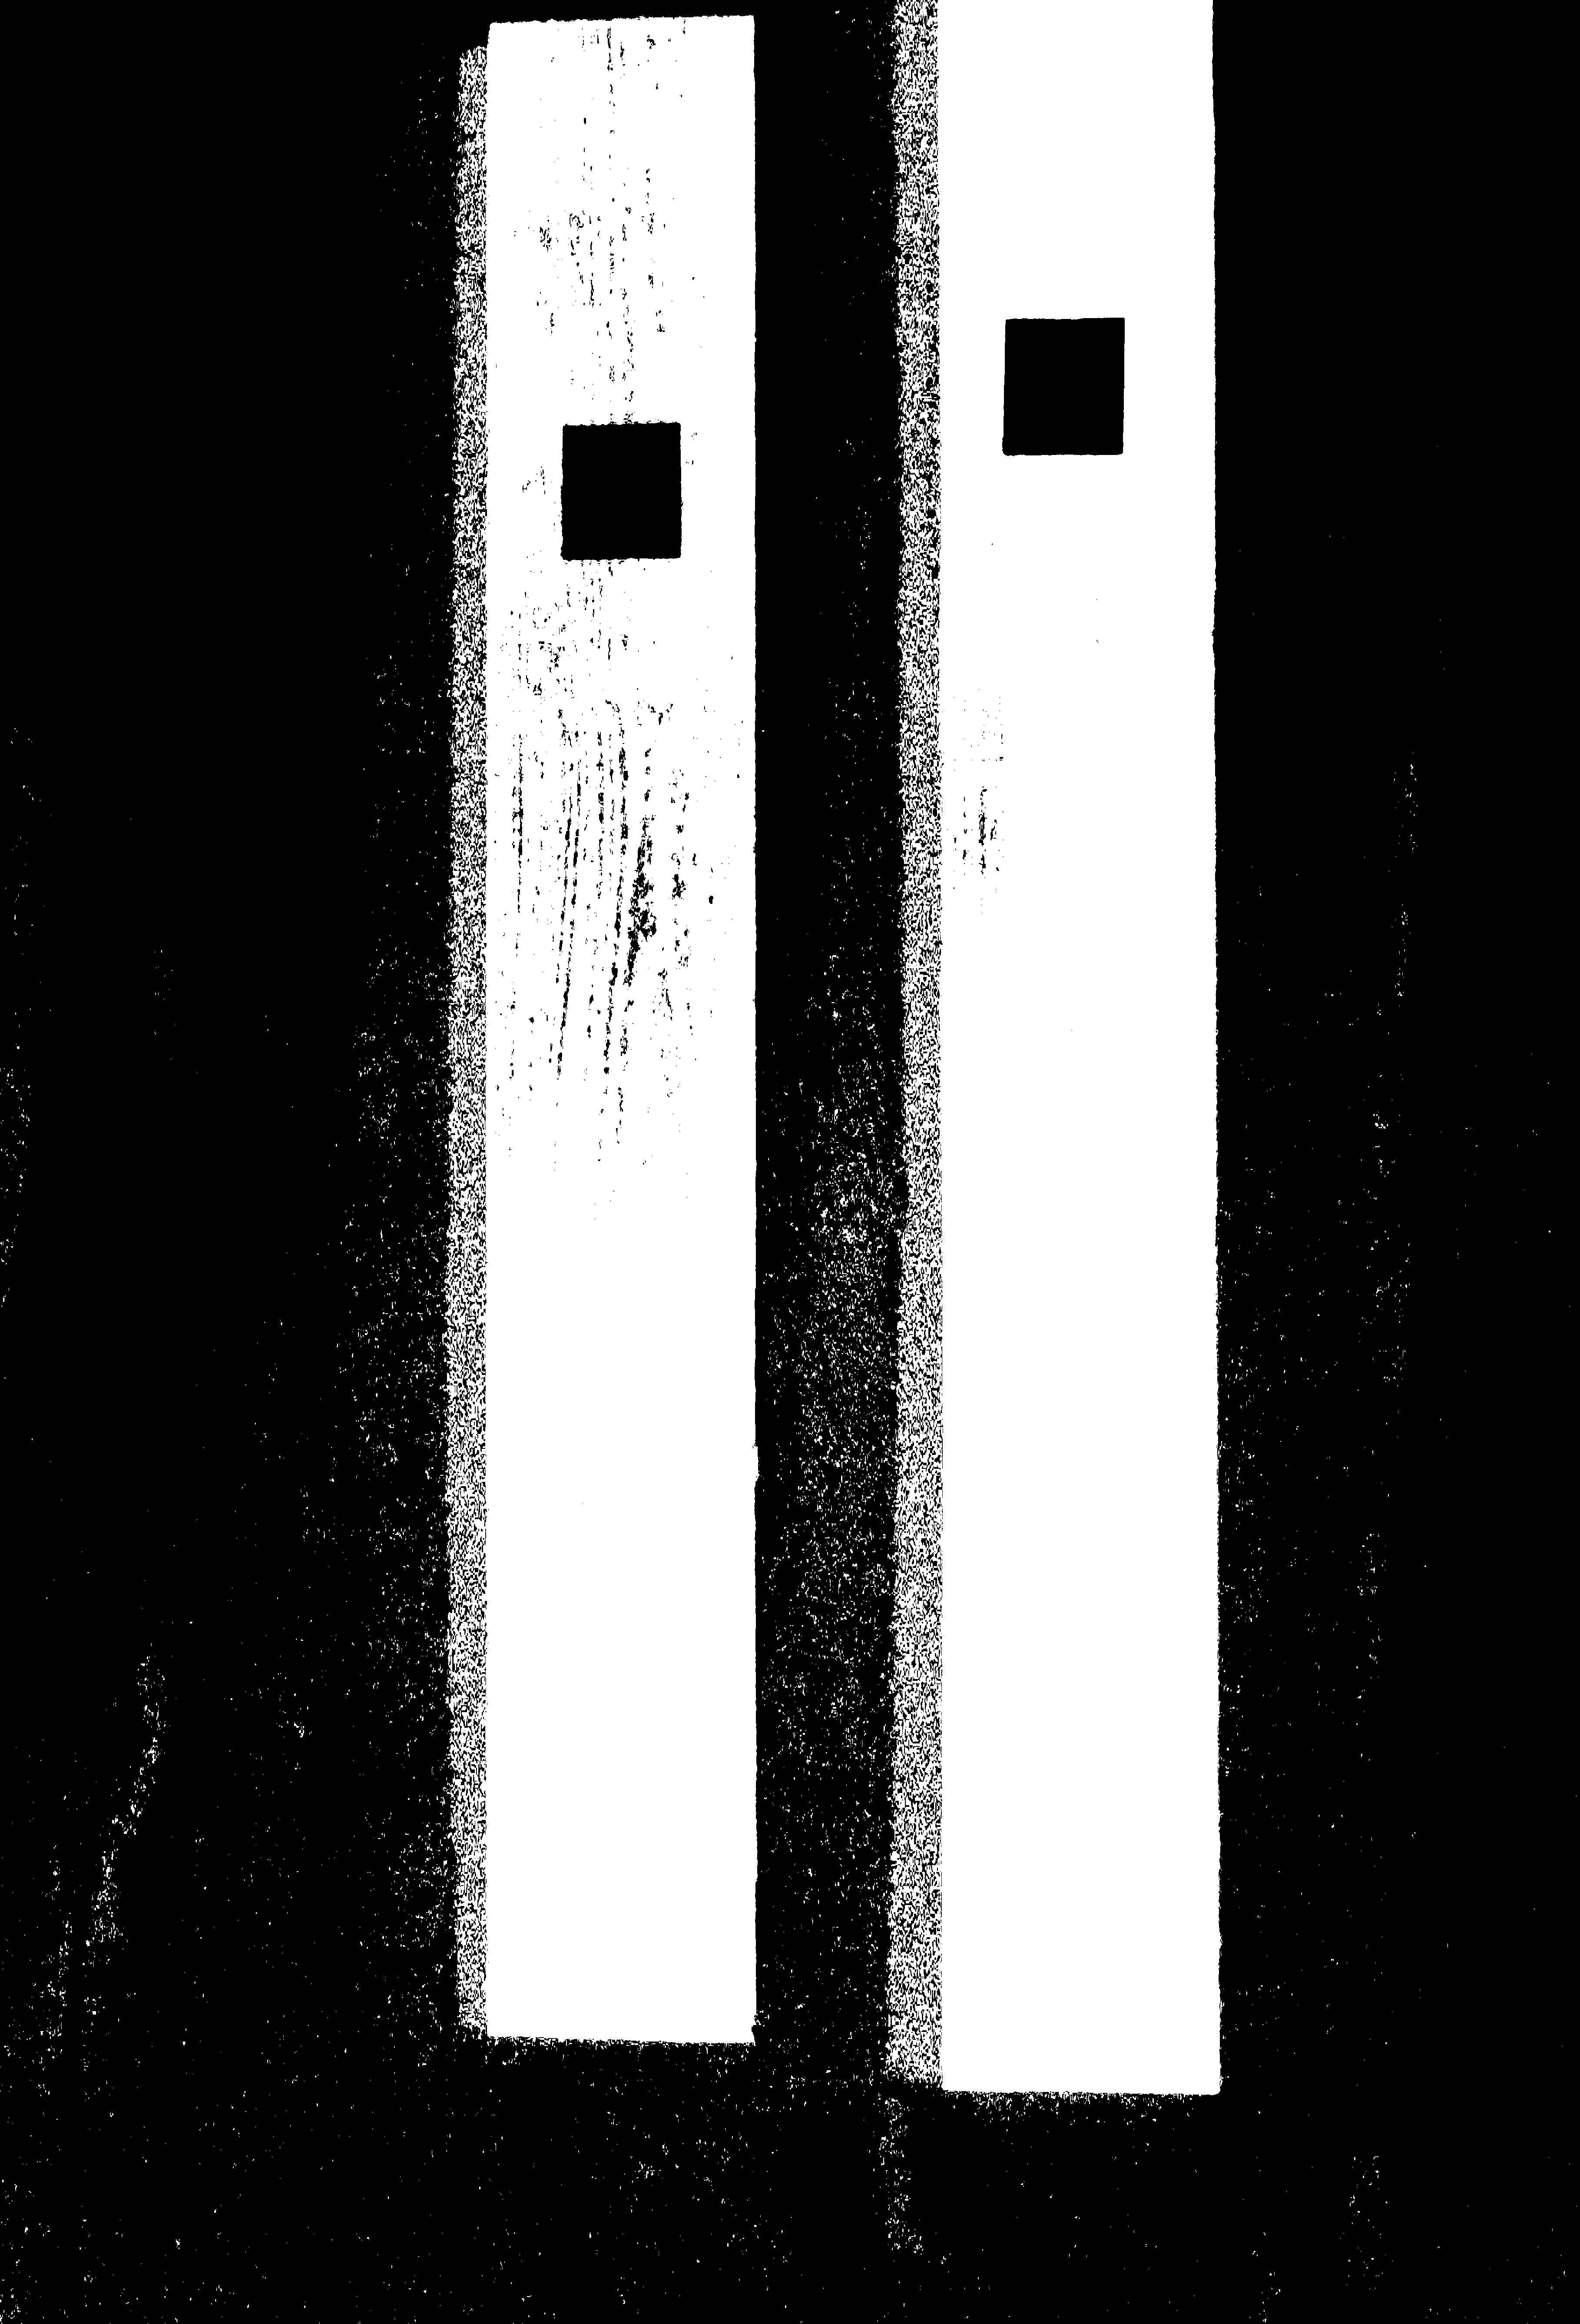

In [70]:
path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/captures'
img_output_path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/exports'
csv_output_path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/data'

for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        file_path = os.path.join(path, filename)

        img = cv2.imread(file_path)
        img = img[220:5568 , 75:3712]

        mask, result = background_subtractor(img)
        cv2_imshow(mask)



In [71]:
path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/captures'
img_output_path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/exports'
csv_output_path = '/content/drive/MyDrive/Robotic_Woodcraft_scanning/data'

for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        file_path = os.path.join(path, filename)

        img = cv2.imread(file_path)
        img = img[220:5568 , 75:3712]
        mask, result = background_subtractor(img)
        corners, ids, detect_img, pixel_to_mm = aruco_detector(result.copy())
        boxes, contour_sorted, length, width, mask_display = image_processor(mask.copy(), result.copy(), corners, ids, pixel_to_mm)
        mask_deep = deepcopy(mask)
        mask_deep = cv2.cvtColor(mask_deep, cv2.COLOR_GRAY2BGR)

        # crop each bouding box and export to a new image
        R, G, B = export_img(result, contour_sorted, img_output_path)

        ids = ids.tolist()
        for i in range(len(ids)):
            ids[i] = ids[i][0]
        data_raw = zip(ids, length, width, R, G, B)
        write_to_csv(data_raw, csv_output_path)

        combine = np.hstack((mask_display, detect_img))

        cv2_imshow(combine)



error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'drawDetectedMarkers'
> Overload resolution failed:
>  - ids data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'ids'
